## Homework_2023_05_15 时间序列 & 神经网络基础   
教师：胡俊峰

助教：谷东润 陈福康

本次作业总分为13分，达到10分即为满分，另外3分是附加分

注意：为提高大家的知识理解与应用能力，时间序列部分需要你自行发挥的内容较多，这些部分在评分时将不会有硬性的步骤要求，而是根据你完成的质量和分析的质量来综合给分（事实上，整体理解与综合分析能力在时间序列问题中是尤为重要的），不必过于纠结某一具体细节是否在评分标准内，加油！


## 第零部分：请认真阅读代码，理解代码的功能

卡尔曼滤波

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
font = {'family': 'SimSun',
        'size': '10.5' 
        }
plt.rc('font', **font)
plt.rc('axes', unicode_minus=False)
 
 
class Kf_Params:
    B = 0  # 外部输入为0
    u = 0  # 外部输入为0
    K = float('nan')  # 卡尔曼增益无需初始化
    z = float('nan')  # 这里无需初始化，每次使用kf_update之前需要输入观察值z
    P = np.diag(np.ones(4))  # 初始P设为0 
 
    # 初始状态：函数外部提供初始化的状态，本例使用观察值进行初始化，vx，vy初始为0
    x = []
    G = []
 
    # 状态转移矩阵A
    # 和线性系统的预测机制有关，这里的线性系统是上一刻的位置加上速度等于当前时刻的位置，而速度本身保持不变
    A = np.eye(4) + np.diag(np.ones((1, 2))[0, :], 2)
 
    # 预测噪声协方差矩阵Q：假设预测过程上叠加一个高斯噪声，协方差矩阵为Q
    # 大小取决于对预测过程的信任程度。比如，假设认为运动目标在y轴上的速度可能不匀速，那么可以把这个对角矩阵
    # 的最后一个值调大。有时希望出来的轨迹更平滑，可以把这个调更小
    Q = np.diag(np.ones(4)) * 0.1
 
    # 观测矩阵H：z = H * x
    # 这里的状态是（坐标x， 坐标y， 速度x， 速度y），观察值是（坐标x， 坐标y），所以H = eye(2, 4)
    H = np.eye(2, 4)
 
    # 观测噪声协方差矩阵R：假设观测过程上存在一个高斯噪声，协方差矩阵为R
    # 大小取决于对观察过程的信任程度。比如，假设观测结果中的坐标x值常常很准确，那么矩阵R的第一个值应该比较小
    R = np.diag(np.ones(2)) * 0.1
 
 
def kf_init(px, py, vx, vy):
    # 本例中，状态x为（坐标x， 坐标y， 速度x， 速度y），观测值z为（坐标x， 坐标y）
    kf_params = Kf_Params()
    kf_params.B = 0
    kf_params.u = 0
    kf_params.K = float('nan')
    kf_params.z = float('nan')
    kf_params.P = np.diag(np.ones(4))
    kf_params.x = [px, py, vx, vy]
    kf_params.G = [px, py, vx, vy]
    kf_params.A = np.eye(4) + np.diag(np.ones((1, 2))[0, :], 2)
    kf_params.Q = np.diag(np.ones(4)) * 0.1
    kf_params.H = np.eye(2, 4)
    kf_params.R = np.diag(np.ones(2)) * 0.1
    return kf_params
 
 
def kf_update(kf_params):
    # 以下为卡尔曼滤波的五个方程（步骤）
    a1 = np.dot(kf_params.A, kf_params.x)
    a2 = kf_params.B * kf_params.u
    x_ = np.array(a1) + np.array(a2)
 
    b1 = np.dot(kf_params.A, kf_params.P)
    b2 = np.dot(b1, np.transpose(kf_params.A))
    p_ = np.array(b2) + np.array(kf_params.Q)
 
    c1 = np.dot(p_, np.transpose(kf_params.H))
    c2 = np.dot(kf_params.H, p_)
    c3 = np.dot(c2, np.transpose(kf_params.H))
    c4 = np.array(c3) + np.array(kf_params.R)
    c5 = np.linalg.matrix_power(c4, -1)
    kf_params.K = np.dot(c1, c5)
 
    d1 = np.dot(kf_params.H, x_)
    d2 = np.array(kf_params.z) - np.array(d1)
    d3 = np.dot(kf_params.K, d2)
    kf_params.x = np.array(x_) + np.array(d3)
 
    e1 = np.dot(kf_params.K, kf_params.H)
    e2 = np.dot(e1, p_)
    kf_params.P = np.array(p_) - np.array(e2)
 
    kf_params.G = x_
    return kf_params
 
 
def accuracy(predictions, labels):
    return np.array(predictions) - np.array(labels)
 


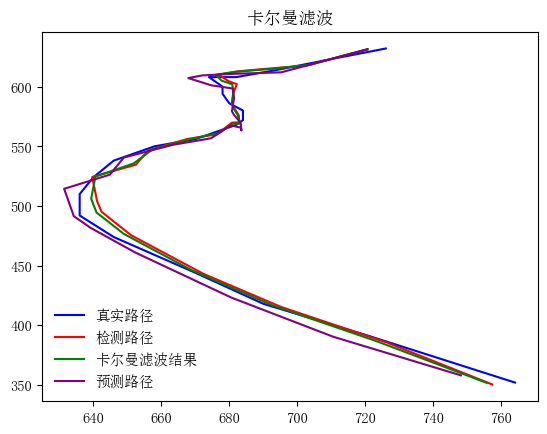

[[-5.4        -0.7       ]
 [-4.58181818 -3.77727273]
 [-1.86696035  0.88942731]
 [ 0.20809969  4.51825545]
 [ 2.00056586  1.98601069]
 [ 1.70377857  1.05589697]
 [ 2.85716089  1.93268741]
 [ 3.16304702  1.44725796]
 [ 0.82221324  0.45770473]
 [-2.79698331  2.02862495]
 [-1.45543694  1.89218001]
 [-1.02643566 -2.58195893]
 [ 1.01894224  0.95448879]
 [ 1.16876094  3.06887511]
 [ 1.10734916 -0.57406179]
 [-1.14701401  0.2172807 ]
 [-0.51547091 -2.48551873]
 [ 5.87618882 -2.3240735 ]
 [ 0.62070854  0.64769776]
 [ 3.37747443 -3.98289077]
 [ 4.95143595  2.53441544]
 [ 2.99332009  2.57928957]
 [-1.17946821  2.29714653]
 [ 2.60174957 -1.21233093]
 [ 3.49455815 -5.54628404]
 [-8.34041064 -0.23971885]]


In [2]:
path = '9.xlsx'
data_A = pd.read_excel(path, header=None)
data_A_x = list(data_A.iloc[::, 0])
data_A_y = list(data_A.iloc[::, 1])
A = np.array(list(zip(data_A_x, data_A_y)))

plt.figure()
plt.plot(data_A_x, data_A_y, 'blue')

# 检测到的路径
path = '10.xlsx'
data_B = pd.read_excel(path, header=None)
data_B_x = list(data_B.iloc[::, 0])
data_B_y = list(data_B.iloc[::, 1])
B = np.array(list(zip(data_B_x, data_B_y)))

plt.plot(data_B_x, data_B_y, 'red')

# 卡尔曼滤波
kf_params_record = np.zeros((len(data_B), 4))
kf_params_p = np.zeros((len(data_B), 4))
t = len(data_B)
kalman_filter_params = kf_init(data_B_x[0], data_B_y[0], 0, 0)
for i in range(t):
    if i == 0:
        kalman_filter_params = kf_init(data_B_x[i], data_B_y[i], 0, 0)  # 初始化
    else:            
        kalman_filter_params.z = np.transpose([data_B_x[i], data_B_y[i]])  # 设置当前时刻的观测位置
        kalman_filter_params = kf_update(kalman_filter_params)  # 卡尔曼滤波
    kf_params_record[i, ::] = np.transpose(kalman_filter_params.x)
    kf_params_p[i, ::] = np.transpose(kalman_filter_params.G)

kf_trace = kf_params_record[::, :2]
kf_trace_1 = kf_params_p[::, :2]

plt.plot(kf_trace[::, 0], kf_trace[::, 1], 'green')
plt.plot(kf_trace_1[1:26, 0], kf_trace_1[1:26, 1], 'purple')
legend = ['真实路径', '检测路径', '卡尔曼滤波结果', '预测路径']
plt.legend(legend, loc="best", frameon=False)
plt.title('卡尔曼滤波')
plt.show()

p = accuracy(kf_trace, A)
print(p)

## 第一部分：时间序列（8分）

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

df = pd.read_csv('Stock_Price.csv')
df.head()


,Date,TWTR,KO,GM
0,2013-11-07,44.900002,30.350573,27.762348
1,2013-11-08,41.650002,30.518206,28.334280
2,2013-11-11,42.900002,30.381044,28.349743
3,2013-11-12,41.900002,30.388666,28.334280
4,2013-11-13,42.599998,30.571535,29.710032


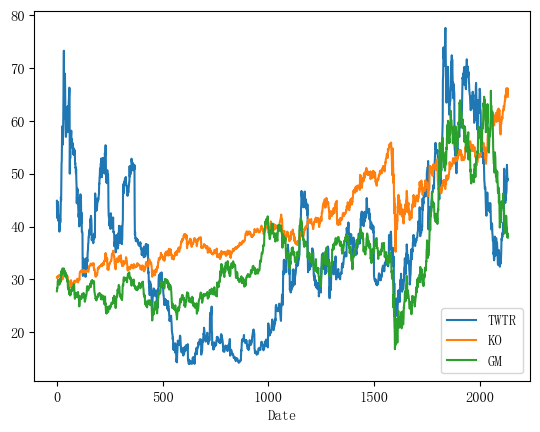

In [4]:
df[['TWTR', 'KO', 'GM']].plot()
plt.xlabel('Date')
plt.show()

1.1 请你结合课上老师讲授的知识、上次作业以及其它查阅得到的知识，对这三支股票的股价时间序列的基本性质与特征（平稳性、周期性等）进行分析，并可以尝试分析三支股票是否有（或在某些局部的时间段有）关联（2分）

In [5]:
# ADF平稳性检验
from statsmodels.tsa.stattools import adfuller
stokes = ['TWTR', 'KO', 'GM']
for stoke in stokes:
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df[stoke])
    print(f'Stoke {stoke}, ADF: {adf}, p_val: {pvalue}')
# 分析:
# TWTR在40附近波动，具有平稳性
# KO有明显的上升趋势，不具平稳性
# GM当date < 1500时，在25附近波动，date > 1500时，有一定上升，具有一定平稳性，但不如TWTR

Stoke TWTR, ADF: -2.10726596748235, p_val: 0.24160297489559313
Stoke KO, ADF: 0.04024578111864399, p_val: 0.9617365050440164
Stoke GM, ADF: -1.7468451155639946, p_val: 0.40715227267731047


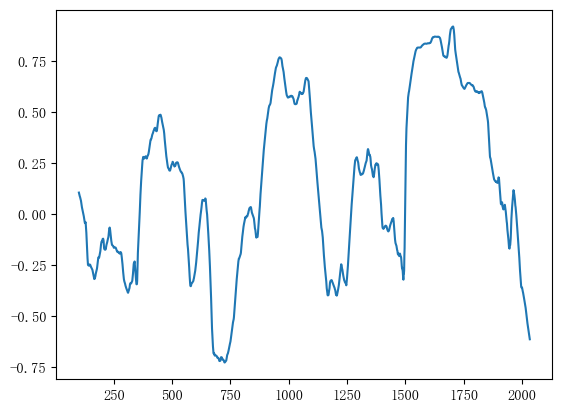

In [6]:
# 对KO和GM进行相关分析
r_window_size = 200
stoke_1 = df['KO']
stoke_2 = df['GM']
rolling_r = stoke_1.rolling(window=r_window_size, center=True).corr(stoke_2)
plt.plot(rolling_r)
plt.show()
# 分析
# 两支股票在date = 750前后呈较强的负相关性，在date = 1000和1750前后呈较强的正相关性

1.2 请你自行发挥，根据你对于时间序列的理解并结合上网查阅资料，给出一些股票时间序列能反映趋势或可以用来预测涨跌的指标（你也可以尝试进行自定义指标），给出指标的定义以及计算指标的代码，并借助该股票数据分析效果（4分）

（没有思路的同学可以尝试计算分析股票的KDJ指标和双均线指标，分析合理即可）

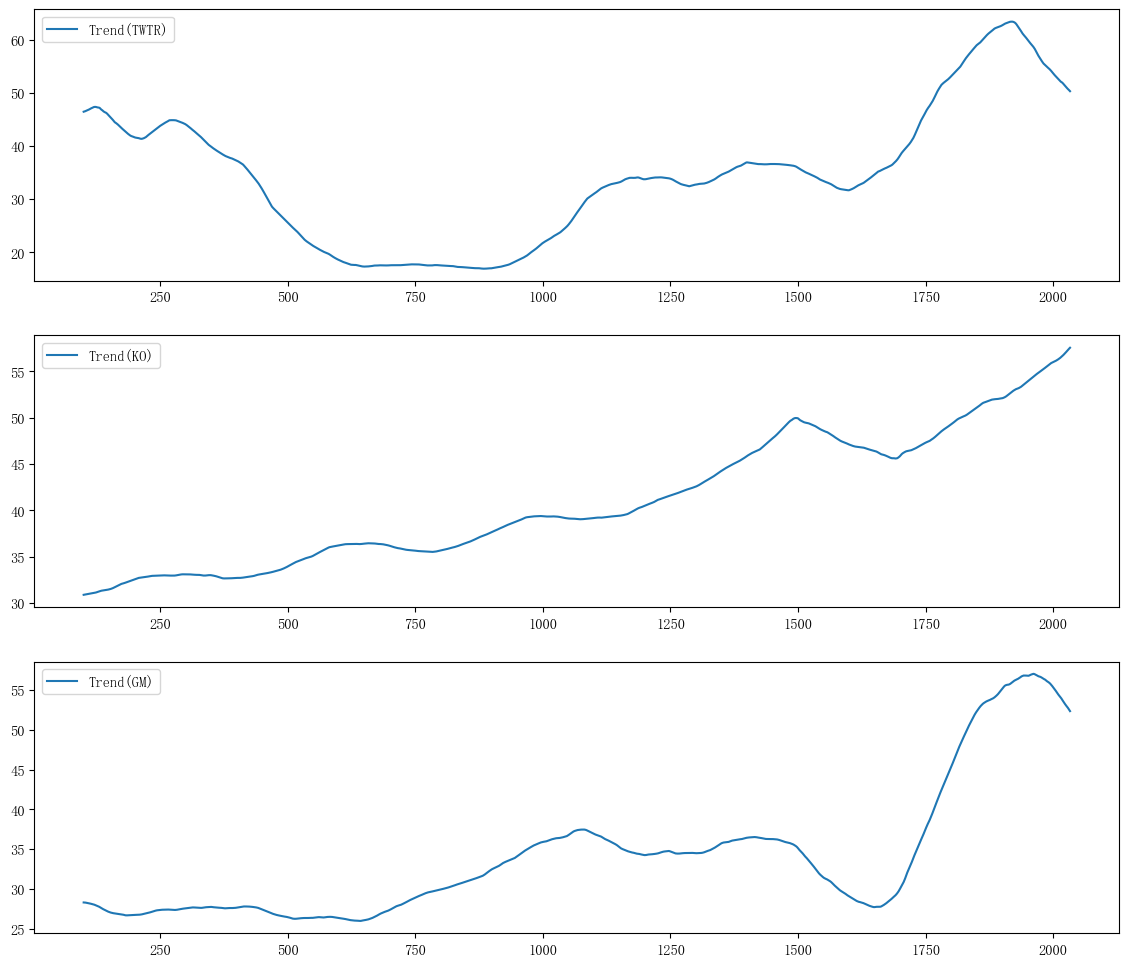

In [7]:
# 使用seasonal decompose得到趋势
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose(ts, p=200):
    decomp = seasonal_decompose(ts, period=p)
    return decomp.trend

plt.figure(figsize=(14,12))
for i, stoke in enumerate(stokes):
    plt.subplot(3, 1, i+1)
    plt.plot(decompose(df[stoke], p=200), label=f'Trend({stoke})')
    plt.legend()

plt.show()

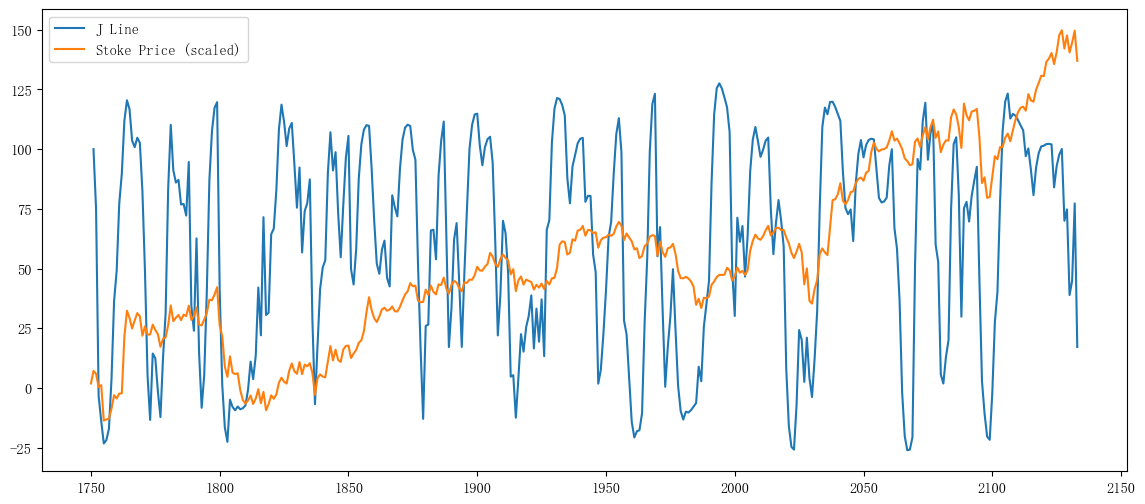

In [8]:
# KDJ指标，以J线分析KO
def KDJ(ts):
    low_list = ts.rolling(9, min_periods=9).min()
    low_list.fillna(value=ts.expanding().min(), inplace=True)
    high_list = ts.rolling(9, min_periods=9).max()
    high_list.fillna(value=ts.expanding().max(), inplace=True)
    rsv = (ts - low_list) / (high_list - low_list) * 100
    k = pd.DataFrame(rsv).ewm(com=2).mean()
    d = k.ewm(com=2).mean()
    j = 3 * k - 2 * d
    return k, d, j
k, d, j = KDJ(df['KO'][1750:])
plt.figure(figsize=(14,6))
plt.plot(j, label='J Line')
plt.plot((df['KO'][1750:] - df['KO'][1750:].mean()) * 8 + df['KO'][1750:].mean(), label='Stoke Price (scaled)')
plt.legend()
plt.show()
# 分析
# J线较大时，股价达到短期极大
# J线较小时，股价达到短期极小

In [ ]:
# 双均线分析KO
ma5 = df['KO'][1750:].rolling(5).mean()
ma30 = df['KO'][1750:].rolling(30).mean()
plt.figure(figsize=(14,6))
plt.plot(df['KO'][1750:], label='Origin')
plt.plot(ma5, label='MA5', linewidth=3)
plt.plot(ma30, label='MA30', linewidth=3)

plt.legend()
plt.show()
# 分析
# 如在约1825-1910左右出现金叉(短时间的指标线方向拐头向上，并且穿过了较长时间的指标线)，操作趋向买入

1.3 噪声处理（2分）

example.wav中录制了一段鸟鸣声，但背景中存在很大的噪声，希望能编写一段程序去除噪声。这里采用的是librosa库，有关内容可参考其官方文档https://librosa.org/doc/latest/tutorial.html
<br>（1）绘制音频文件example.wav的图像。
<br>（2）去除音频文件中的噪声。（可使用scipy.signal.lfilter）https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html
<br>（3）绘制去除噪声后的音频文件图像。

In [9]:
import librosa
import librosa.display
from scipy import signal
from IPython.display import Audio,display

sr = 16000
e_file='example.wav'
y,sr = librosa.load(e_file, mono=True, sr=sr, offset=0, duration=10)

display(Audio(y,rate=sr))

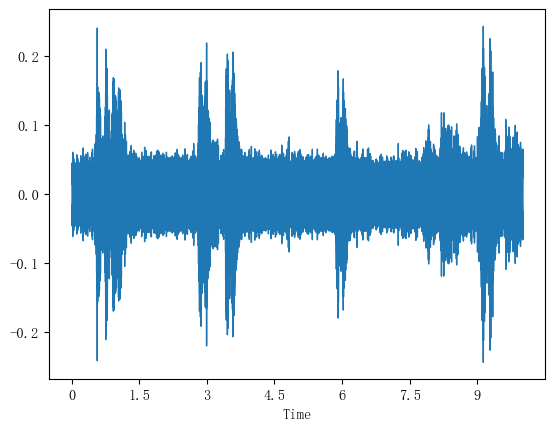

In [10]:
librosa.display.waveshow(y,sr=sr)

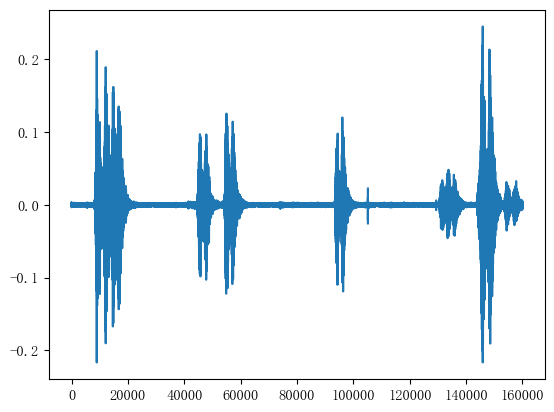

In [11]:
#todo
b, a = signal.butter(4, 0.5, btype='highpass')
z = signal.lfilter(b, a, y)
z2 = signal.lfilter(b, a, z)
plt.plot(z2)
plt.show()

## 第二部分：神经网络基础(5分)

2.1补全下列常用的激活函数及其导数,熟记并画出它们的图像（2分），你也可以查阅资料后补充一些其它常用的激活函数（不计分）

In [12]:
def sigmoid(x):
    #todo
    return 1.0/(1.0 + np.exp(-x))

def d_sigmoid(x):
    #todo
    return sigmoid(x) - sigmoid(x) ** 2

def ReLU(x):
    #todo
    return max(0,x)

def d_ReLU(x):
    #todo
    return float(x >= 0.0)

def Tanh(x):
    #todo
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def d_Tanh(x):
    #todo
    return 1 - Tanh(x) ** 2


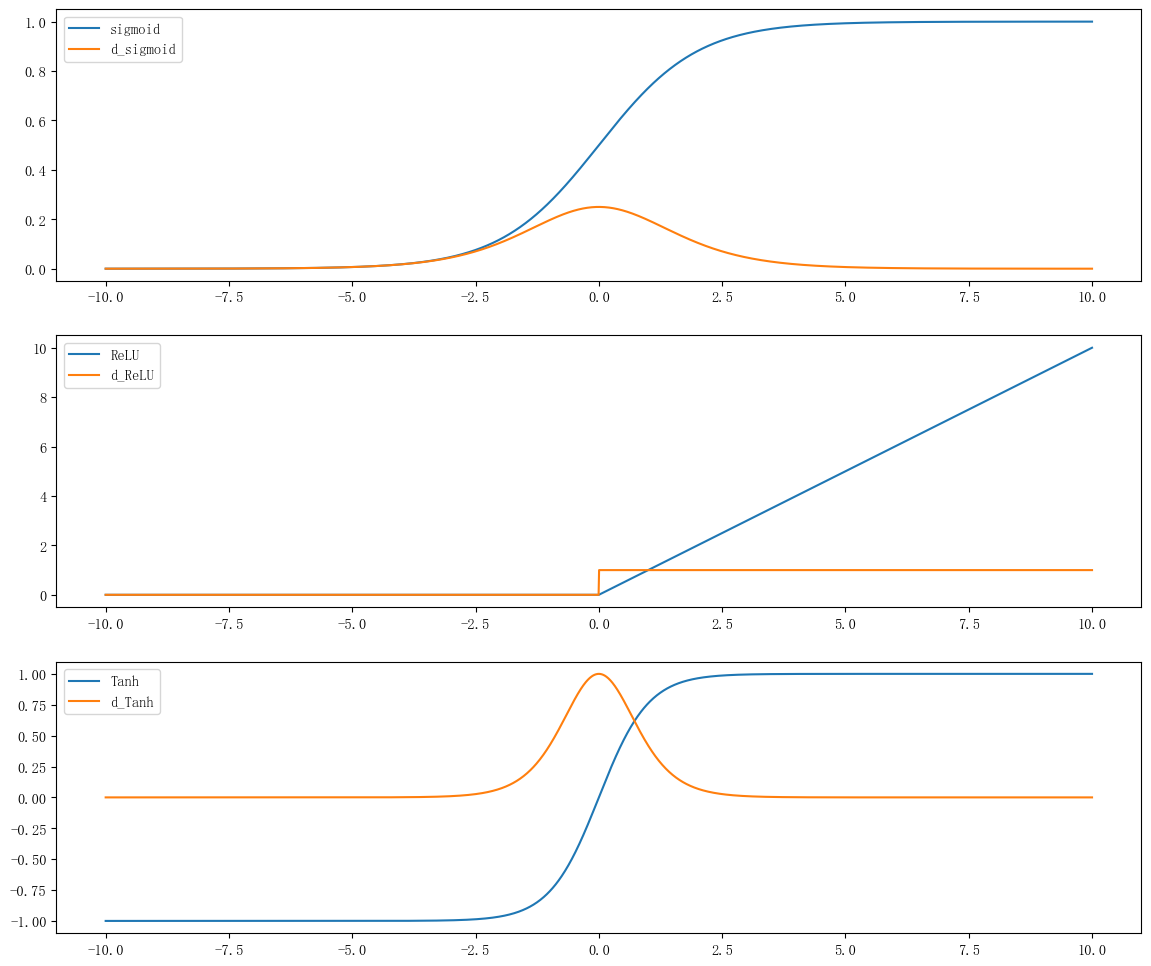

In [13]:
#画出上述常用激活函数与对应导数在区间[-10,10]的图像
#todo
funcs = [[sigmoid, d_sigmoid], [ReLU, d_ReLU], [Tanh, d_Tanh]]
plt.figure(figsize=(14, 12))
for i, func in enumerate(funcs):
    x = np.linspace(-10, 10, 2000)
    y = np.array([func[0](xx) for xx in x])
    dy = np.array([func[1](xx) for xx in x])
    plt.subplot(3, 1, i+1)
    
    plt.plot(x, y, label=func[0].__name__)
    plt.plot(x, dy, label=func[1].__name__)
    plt.legend()
plt.show()

2.2使用反向传播算法，用三次函数拟合sin(x)函数在$[-\pi,\pi]$区间的取值（3分）

In [14]:
import matplotlib.pyplot as plt
import numpy as np
 
import  numpy as np
import math
#在区间等距离散采样
x = np.linspace(-math.pi,math.pi,200)
y = np.sin(x)

In [15]:
#初始化a+b*x+c*x^2+d*x^3中的参数a,b,c,d
a = np.random.randn()
b = np.random.randn()
c = np.random.randn()
d = np.random.randn()

learning_rate = 1e-5    #可尝试对比不同的学习率，不计分

In [16]:
for t in range(6000):
    y_pred = a + b*x + c*x**2 + d*x**3
    
    #计算loss（0.5分）
    #todo
    loss = ((y_pred - y) ** 2).sum()
 
    print(t, loss)
    
    #反向传播（1分）
    #todo
    grad = 2 * (y_pred - y) 
 
    # 更新参数（1分）
    #todo
    a = a - grad.sum() * learning_rate
    b = b - (grad * x).sum() * learning_rate
    c = c - (grad * x ** 2).sum() * learning_rate
    d = d - (grad * x ** 3).sum() * learning_rate

print(f'Result: y = {a} + {b} x + {c} x^2 + {d} x^3')


0 1827.8907944898965
1 420.7085525560518
2 159.27563373319478
3 104.15195929101442
4 87.19855631007201
5 78.16189056851883
6 71.46336112261804
7 65.96121730103536
8 61.329368532519695
9 57.40664127830097
10 54.07747525314096
11 51.248069857185925
12 48.8399866248528
13 46.78720622138915
14 45.03408511906963
15 43.53371106798136
16 42.24653051091099
17 41.13919379529172
18 40.18358196598062
19 39.355986290016
20 38.636416491029124
21 38.00801749287474
22 37.456577650205126
23 36.97011411545791
24 36.538523242982905
25 36.15328582891566
26 35.80721858555232
27 35.494264598127025
28 35.209316649419286
29 34.94806825671856
30 34.70688807433238
31 34.48271399664394
32 34.27296387159474
33 34.07546021917011
34 33.888366758136854
35 33.71013488885351
36 33.53945857049679
37 33.37523627600024
38 33.216538914533466
39 33.062582785484636
40 32.91270677473199
41 32.76635312778085
42 32.62305123871877
43 32.48240398194292
44 32.34407618781452
45 32.207784925955096
46 32.07329131264757
47 31.940393

画出得到的三次函数与sinx在$[-\pi,\pi]$区间内的图像(0.5分)

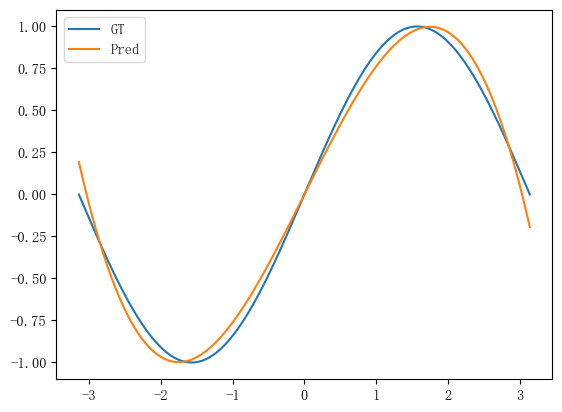

In [17]:
#todo
plt.plot(x, y, label='GT')
plt.plot(x, a + b*x + c*x**2 + d*x**3, label='Pred')
plt.legend()
plt.show()